In [1]:
import mpmath as mp
from math import *
import cmath as cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import optimize

def kp(k):
    return sqrt(1-k**2)

# Constant
e0 = 8.85*10**(-12)
mu0 = 4*pi*10**(-7)
c = 299792458

### 1.1 Half wavelength CPW basic calculations 
https://doi.org/10.1063/1.3010859

Qint is 8555.535548991807
50gap has Qext = 4.88e+06
5gap has Qext = 2.21e+05
30ex has Qext = 6.69e+03
ETH has Qext = 4.76e+03
1+2 has Qext = 2.64e+03
2+2 has Qext = 1.12e+03


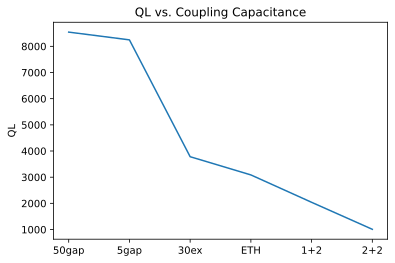

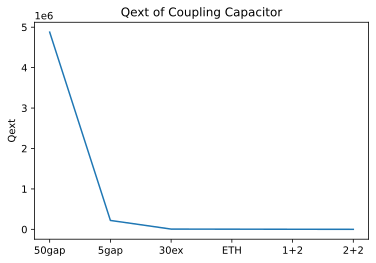

In [2]:
# Geometry
# centor conductor width
w = 10e-6
# ground gap width
s = 7.1e-6
# length
l = 10.2e-3
# effective permittivity
eff = (1+11)/2

# fundamental frequency
f0 = c/sqrt(eff)/(2*l)

# capacitance and inductance per unit length
k0 = w/(w+2*s)
Ll = mu0/4*mp.ellipk(kp(k0))/mp.ellipk(k0)
Cl = 4*e0*eff*mp.ellipk(k0)/mp.ellipk(kp(k0))
# characteristic impedance
Z0 = sqrt(Ll/Cl)

# Around resonance
####### Undertermined attenuation constant
alpha = 1.8*10**-2
# alpha = 2.4*10**-4
n = 1
RL = 50

Ln = 2*Ll*l/(n**2*pi**2)
C = Cl*l/2
R = Z0/(alpha*l)

Qint = R*sqrt(C/Ln)
print('Qint is ' + str(float(Qint)))

# Coupling Capacitance
names = ['50gap', '5gap', '30ex', 'ETH', '1+2', '2+2']
Ck_arr = np.array([0.2, 0.94, 5.4, 6.4, 8.6, 13.2])*1e-15
QL_arr = []
Qext_arr = []

# QL and Qext from (21)
for i in range(Ck_arr.shape[0]):
    Ck = Ck_arr[i]
    wn = 1/sqrt(Ln*C)
    Rstar = (1 + wn**2*Ck**2*RL**2)/(wn**2*Ck**2*RL)
    Cstar = Ck/(1 + wn**2*Ck**2*RL**2)
    wnstar = 1/sqrt(Ln*(C+2*Cstar))

    QL = wnstar*(C+2*Cstar)/(1/R+2/Rstar)
    QL_arr.append(QL)
    
    Qext = wn*Rstar*C/2
    Qext_arr.append(float(Qext))
    print(f'{names[i]} has Qext = {float(Qext):0.2e}')
    
Qext_arr = np.array(Qext_arr)
    
plt.figure()
plt.plot(names, QL_arr)
plt.ylabel('QL')
plt.title("QL vs. Coupling Capacitance")
plt.show()

# Qext from (21)
plt.figure()
plt.plot(names, Qext_arr)
plt.title('Qext of Coupling Capacitor')
plt.ylabel('Qext')
plt.show()

### 1.2 S21 ABCD(Transmission) Matrix 
Refer Gopple eq.23 - eq-28

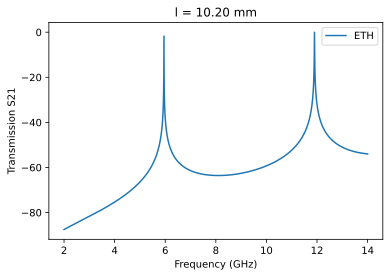

In [3]:
v_ph = float(1/np.sqrt(Ll*Cl))
w_0 = float(1/sqrt(Ln*C))
Z0 = float(np.sqrt(Ll/Cl))

w = np.linspace(2, 14, 10000)*2*pi*1e9

plt.figure()

for ci in range(Ck_arr.shape[0]):
    S21 = []
    
    if(ci == 3):

        for wi in w:
            alpha = 2.4e-4
            beta = float(wi/v_ph)
            gamma = alpha + 1j*beta

            t11 = np.cosh(gamma*l)
            t12 = Z0*np.sinh(gamma*l)
            t21 = 1/Z0*np.sinh(gamma*l)
            t22 = np.cosh(gamma*l)

            MT = np.array([[t11, t12],[t21, t22]])

            Z_in_out = 1/(1j*wi*Ck_arr[ci])
            MZ = np.array([[1, Z_in_out], [0, 1]])
            M_result = MZ @ MT @ MZ
            S21.append(2/(M_result[0][0] + M_result[0][1]/RL + M_result[1][0]*RL + M_result[1][1]))

        plt.plot(w/(2*pi)*1e-9, 20*np.log10(np.abs(S21)), label = f'{names[ci]}')
# plt.plot(w/(2*pi)*1e-9, np.angle(S21))

plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission S21')
plt.title(f'l = {l*1e3:.2f} mm')
plt.legend()
plt.show()

In [4]:
def S21_spec(f, l0, eff0, alpha0, ck0, log = True):
    w0 = 10e-6
    s0 = 7.1e-6
    RL = 50
    
    k00 = w0/(w0+2*s0)
    Ll0 = float(mu0/4*mp.ellipk(kp(k00))/mp.ellipk(k00))
    Cl0 = float(4*e0*eff0*mp.ellipk(k00)/mp.ellipk(kp(k00)))
    C0 = Cl0*l0/2
    n0=1
    Ln0 = 2*Ll0*l0/(n0**2*np.pi**2)
    
    v_ph0 = float(1/np.sqrt(Ll0*Cl0))
    w_00 = float(1/sqrt(Ln0*C0))
    Z00 = float(np.sqrt(Ll0/Cl0))
    
    w = f*2*np.pi
    S210 = []
    
    for wi in w:
        beta0 = wi/v_ph0
        gamma0 = alpha0 + 1j*beta0

        t110 = np.cosh(gamma0*l0)
        t120 = Z00*np.sinh(gamma0*l0)
        t210 = 1/Z00*np.sinh(gamma0*l0)
        t220 = np.cosh(gamma0*l0)

        MT0 = np.array([[t110, t120],[t210, t220]])

        Z_in_out0 = 1/(1j*wi*ck0)
        MZ0 = np.array([[1, Z_in_out0], [0, 1]])
        M_result0 = MZ0 @ MT0 @ MZ0
        S210.append(2/(M_result0[0][0] + M_result0[0][1]/RL + M_result0[1][0]*RL + M_result0[1][1]))
    if log == True:
        return 20*np.log10(np.abs(S210))
    else:
        return S210

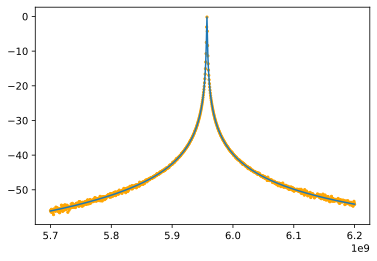

In [5]:
f = np.linspace(5.7, 6.2, 1000)*1e9
rng = np.random.default_rng()
y_noise = 0.0001* rng.normal(size=len(f))
ydata = np.abs(S21_spec(f, 10.2e-3, 6, 2.4e-4, 5.4e-15, log = False)) + y_noise
ydata = np.where(ydata > 1, 1, ydata)
ydata = np.where(ydata == 1, 0.99999, ydata)
ydata = np.where(ydata < 0, -ydata, ydata)
plt.plot(f, S21_spec(f, 10.2e-3, 6, 2.4e-4, 5.4e-15))
plt.scatter(f, 20*np.log10(ydata), s = 5, c = 'orange')

In [6]:
popt, pcov = optimize.curve_fit(S21_spec, f, 20*np.log10(ydata), bounds = ([10e-3, 5, 1e-4, 0],[11e-3, 7, 0.1, 20e-15]), maxfev=5000)
popt

array([1.01463277e-02, 6.06394073e+00, 2.20220941e-04, 5.41131560e-15])

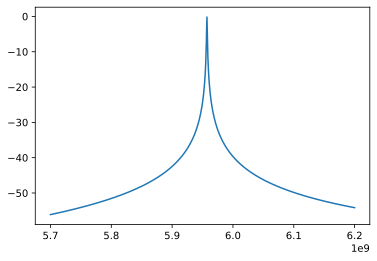

In [7]:
plt.plot(f, S21_spec(f, *popt))

### 2.1 HFSS simulation ET2 fitting
Lorentzian lineshape fitting is not very accurate and useful.

S21 ABCD matrix fitting works well and gives more information.

In [8]:
import skrf as rf
from skrf import Network

In [9]:
ET2 = Network('/Users/shenzhuo/Downloads/CPW_ET2_ET2_SC_2D.s2p') #['5.663-5.666 GHz']
ET2_s1 = Network('/Users/shenzhuo/Downloads/CPW_ET2_ET2_SC_2D_s1.s2p') #['5.663-5.666 GHz']

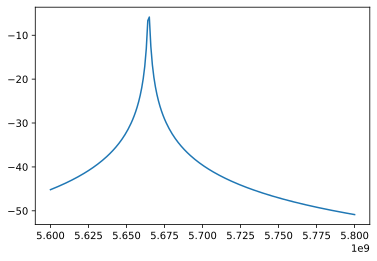

In [10]:
freq = ET2_s1.f
S21_db = ET2_s1.s_db[:,1,0]
S21_mag = ET2_s1.s_mag[:,1,0]

plt.plot(freq, S21_db)

In [11]:
def Lor(x, cen1, wid1, amp1):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2))
def Lor_db(x, cen1, wid1, amp1):
    return 20*np.log10(amp1*wid1**2/((x-cen1)**2+wid1**2))

In [12]:
popt, pcov = optimize.curve_fit(Lor, freq*1e-9, S21_mag, p0 = [5.665, 0.001, 1], maxfev=50000)
print(popt)
QL = popt[0]/popt[1]
print(QL)

[5.66457231e+00 1.62351763e-03 5.14817699e-01]
3489.0734855874102


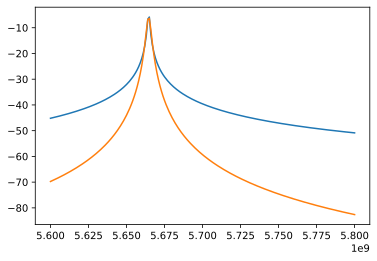

In [13]:
plt.plot(freq, S21_db)
plt.plot(freq, Lor_db(freq*1e-9, *popt))

#### Use ABCD matrix below: 
Need provide an initial guess for the fitting.

In [14]:
popt, pcov = optimize.curve_fit(S21_spec, freq, S21_db, maxfev=50000, method = 'trf',
       p0 = [1.02e-02, 6.65, 1e-02, 5e-15], bounds = ([1.0e-02, 6, 1e-04, 1e-15], [1.1e-02, 7, 1e-01, 10e-15]))
popt

array([1.02015553e-02, 6.64235428e+00, 1.07523736e-02, 5.45750826e-15])

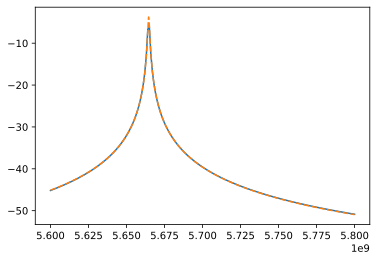

In [15]:
f = np.linspace(5.6,5.8,10000)*1e9
plt.plot(freq, S21_db)
plt.plot(f, S21_spec(f, *popt), '--')

####  Find 3 dB points here

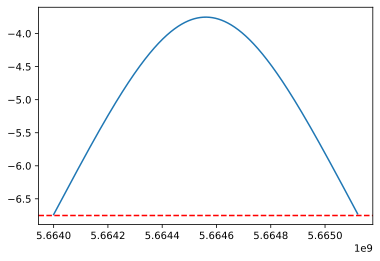

In [16]:
f = np.linspace(5.664, 5.66512, 1000)*1e9
# plt.plot(freq, S21_db)
plt.plot(f, S21_spec(f, *popt))
plt.axhline(S21_spec(f, *popt).max()-3, color='r', linestyle='--')

In [17]:
QL = np.abs((5.664+5.66512)/2/(5.664-5.66512))

In [18]:
alpha = popt[2]
l = popt[0]
Qint = pi/(2*alpha*l)

In [19]:
Qext = (1/QL-1/Qint)**-1
print(QL, Qint, Qext)

5057.64285714181 14320.201896262763 7819.271815441563


### 2.2 Comparison for the thickness of conductor in HFSS
Bascially neglegible difference in thickness considered the complexity for actual CPW and mesh capability

In [20]:
simple_ET = Network('/Users/shenzhuo/Downloads/simple_CPW_ET0_SC_s1.s2p') #['5.663-5.666 GHz']
simple_ET_100nm = Network('/Users/shenzhuo/Downloads/simple_CPW_ET0_SC_100nm_s1.s2p') #['5.663-5.666 GHz']

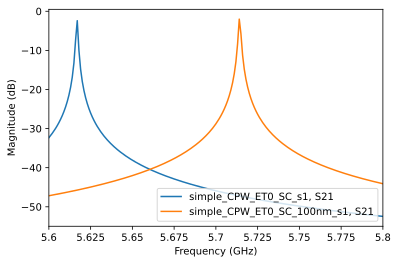

In [21]:
simple_ET.plot_s_db(1,0)
simple_ET_100nm.plot_s_db(1,0)
plt.legend(loc = 'lower right')

In [22]:
freq_sim = simple_ET.f
S21_db_sim = simple_ET.s_db[:,1,0]
freq_sim_100nm = simple_ET_100nm.f
S21_db_sim_100nm = simple_ET_100nm.s_db[:,1,0]

In [23]:
popt, pcov = optimize.curve_fit(S21_spec, freq_sim, S21_db_sim, maxfev=50000, method = 'trf',
       p0 = [1.02e-02, 6.65, 1e-02, 5e-15], bounds = ([1.0e-02, 6, 1e-04, 1e-15], [1.1e-02, 7, 1e-01, 10e-15]))
popt

array([1.02542420e-02, 6.68117641e+00, 5.21801153e-03, 5.85023998e-15])

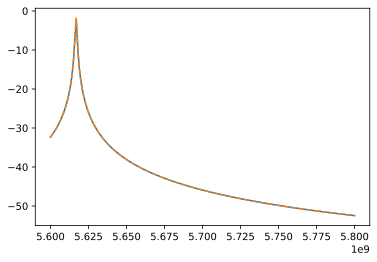

In [24]:
f = np.linspace(5.6,5.8,10000)*1e9
plt.plot(freq_sim, S21_db_sim)
plt.plot(f, S21_spec(f, *popt), '--')

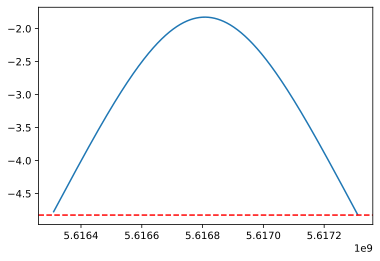

In [25]:
f = np.linspace(5.61631, 5.61731, 1000)*1e9
# plt.plot(freq, S21_db)
plt.plot(f, S21_spec(f, *popt))
plt.axhline(S21_spec(f, *popt).max()-3, color='r', linestyle='--')

In [26]:
QL = -(5.61631+5.61731)/2/(5.61631-5.61731)

In [27]:
alpha = popt[2]
l = popt[0]
Qint = pi/(2*alpha*l)

In [28]:
Qext = (1/QL-1/Qint)**-1
print(QL, Qint, Qext)

5616.810000003113 29356.97333055942 6945.72059496639


In [29]:
popt, pcov = optimize.curve_fit(S21_spec, freq_sim_100nm, S21_db_sim_100nm, maxfev=50000, method = 'trf',
       p0 = [1.02e-02, 6.65, 1e-02, 5e-15], bounds = ([1.0e-02, 6, 1e-04, 1e-15], [1.1e-02, 7, 1e-01, 10e-15]))
popt

array([1.01704672e-02, 6.55065792e+00, 5.55609634e-03, 6.39600669e-15])

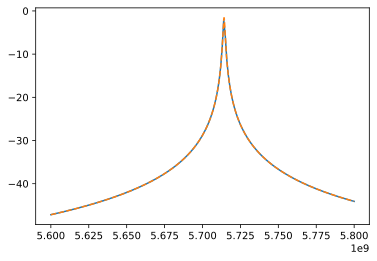

In [30]:
f = np.linspace(5.6,5.8,10000)*1e9
plt.plot(freq_sim_100nm, S21_db_sim_100nm)
plt.plot(f, S21_spec(f, *popt), '--')

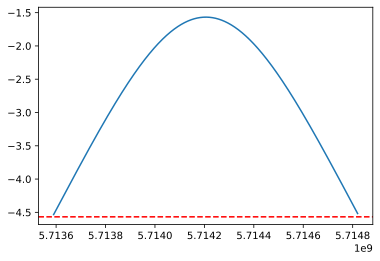

In [31]:
f = np.linspace(5.71359, 5.71482, 1000)*1e9
# plt.plot(freq, S21_db)
plt.plot(f, S21_spec(f, *popt))
plt.axhline(S21_spec(f, *popt).max()-3, color='r', linestyle='--')

In [32]:
QL = -(5.71359+5.71482)/2/(5.71359-5.71482)

In [33]:
alpha = popt[2]
l = popt[0]
Qint = pi/(2*alpha*l)

In [34]:
Qext = (1/QL-1/Qint)**-1
print(QL, Qint, Qext)

4645.695121952654 27797.722031323192 5577.902191796694


### 3. S11 for reflection quarter wavelength

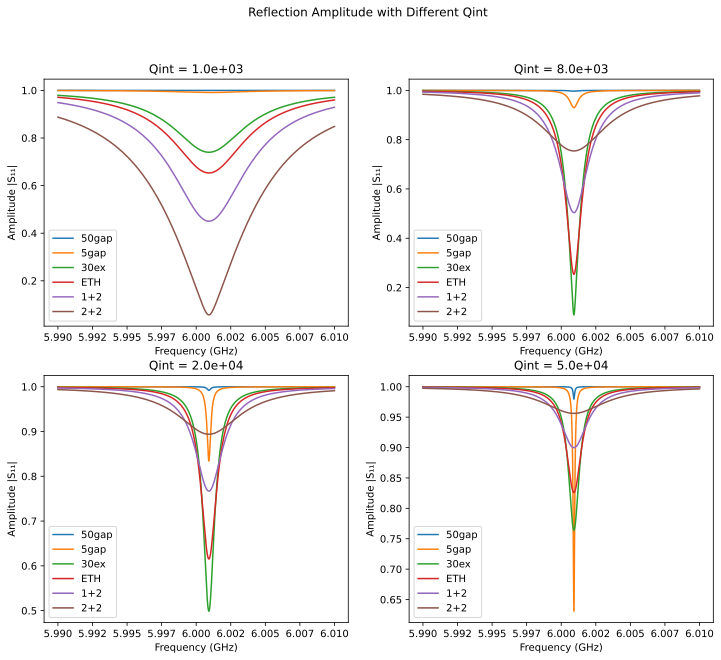

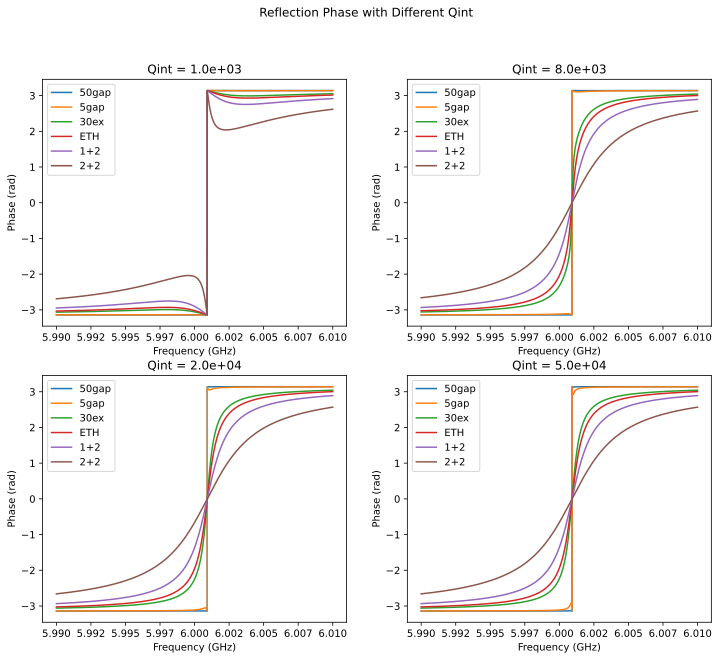

In [35]:
w_0 = float(1/sqrt(Ln*C))
w = np.linspace(5.99, 6.01, 10000)*2*pi*1e9

Qint = np.array([0.1, 0.8, 2, 5])*1e4
kappa_i = w_0/Qint
kappa_e_arr = w_0/Qext_arr

fig1, ax1 = plt.subplots(2,2, figsize = (12,10))
fig2, ax2 = plt.subplots(2,2, figsize = (12,10))

for q in range(kappa_i.shape[0]):
    for i in range(kappa_e_arr.shape[0]):
        S11 = -((w_0-w)*1j + (kappa_i[q]-kappa_e_arr[i])/2)/((w_0-w)*1j + (kappa_i[q]+kappa_e_arr[i])/2)
        
#         plotting amlitude

        ax1[int(q/2), q%2].plot(w/(2*pi)*1e-9, np.abs(S11), label = f'{names[i]}')
        ax1[int(q/2), q%2].legend()
        ax1[int(q/2), q%2].set_xlabel('Frequency (GHz)')
        ax1[int(q/2), q%2].set_ylabel('Amplitude |S\u2081\u2081|')
        ax1[int(q/2), q%2].set_title(f'Qint = {Qint[q]:0.1e}')
        
        ax2[int(q/2), q%2].set_xlabel('Frequency (GHz)')
        ax2[int(q/2), q%2].set_ylabel('Phase (rad)')
        ax2[int(q/2), q%2].set_title(f'Qint = {Qint[q]:0.1e}')
        
#         plotting phase
        
        ax2[int(q/2), q%2].plot(w/(2*pi)*1e-9, np.arctan2(np.imag(S11), np.real(S11)), label = f'{names[i]}')
        ax2[int(q/2), q%2].legend()
        
        ticks_loc = ax1[int(q/2), q%2].get_xticks().tolist()
        ax1[int(q/2), q%2].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax1[int(q/2), q%2].set_xticklabels(['{:.3f}'.format(x) for x in ticks_loc])
        ticks_loc = ax2[int(q/2), q%2].get_xticks().tolist()
        ax2[int(q/2), q%2].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax2[int(q/2), q%2].set_xticklabels(['{:.3f}'.format(x) for x in ticks_loc])
        
        
fig1.suptitle('Reflection Amplitude with Different Qint')
fig2.suptitle('Reflection Phase with Different Qint')

plt.show()